# bikeの特徴量の解釈
https://christophm.github.io/interpretable-ml-book/limo.html

## データの意味

- cnt:casualとregisteredのユーザーの数。回帰のターゲット
- season:spring, summer, fall or winter.
- holiday
- year: 2011 or 2012.
- dateday:2011/01/01からの日数。この特料量は時間経過によるトレンドを導くのに使用する。
- working day or weekend.
- 天気:
    - 1 clear, few clouds, partly cloudy, cloudy
    - 2 mist + clouds, mist + broken clouds, mist + few clouds, mist
    - 3 light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
    - 4 heavy rain + ice pallets + thunderstorm + mist, snow + mist
- temp：Temperature in degrees Celsius.41で割り、正規化されている。
- atemp：体感温度。50で割り、正規化されている。
- hum:湿度(0 to 100). 100で割り正規化されている。
- Wind speed: km/hour.　67で割り、正規化されている。

In [7]:
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import pandas as pd
import seaborn as sns;sns.set()
%matplotlib inline
os.getcwd()

'c:\\ptec\\myproj\\interpretable-machine-learning\\LinearRegression\\FeatureImportance'

In [8]:
data_dir = '../../data/bike'
day_file = 'day.csv'
hour_file = 'hour.csv'

In [9]:
df_day = pd.read_csv(os.path.join(data_dir, day_file))
# headにすることで先頭だけ確認できる。
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [10]:
# ここからデータを整形していく
# 目的変数をYに
Y = df_day['cnt']

#　dteday をなくしt、instantをdayに（本当は日付を経過日数に変換しないと駄目）
del df_day['dteday']
del df_day['yr']

df_day = df_day.rename(columns={'instant': 'days'})

# onehot(季節)
encoder = OneHotEncoder()
enced = encoder.fit_transform(df_day.season.values.reshape(1, -1).transpose())
df_season = pd.DataFrame(index=df_day.season.index, columns=['season-SPRING', 'season-SUMMER', 'season-FALL', "season-WINTER"], data=enced.toarray())
df_day = pd.concat([df_day, df_season], axis=1)
del df_day['season']

# onehot(天気)
encoder = OneHotEncoder()
enced = encoder.fit_transform(df_day.weathersit.values.reshape(1, -1).transpose())
df_weather = pd.DataFrame(index=df_day.weathersit.index, columns=['weather-CLEAR', 'weather-MYST', 'weather-SNOW'], data=enced.toarray())
df_day = pd.concat([df_day, df_weather], axis=1)
del df_day['weathersit']

# 正規化を実施する。
#df_day['temp'] = df_day['temp'] *  (39 - (-8)) + (-8)
#df_day['hum'] = df_day['hum'] * 100
#df_day['windspeed'] = df_day['windspeed'] * 67

# 未使用の特徴量を削除
del df_day['casual']
del df_day['registered']
del df_day['cnt']
del df_day['mnth']
del df_day['weekday']
del df_day['atemp']

# 最終的な特徴量
df_day.head()


C:\Users\morkc\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\morkc\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

,days,holiday,workingday,temp,hum,windspeed,season-SPRING,season-SUMMER,season-FALL,season-WINTER,weather-CLEAR,weather-MYST,weather-SNOW
0,1,0,0,0.344167,0.805833,0.160446,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0,0,0.363478,0.696087,0.248539,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0,1,0.196364,0.437273,0.248309,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,0,1,0.200000,0.590435,0.160296,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,1,0.226957,0.436957,0.186900,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# モデルの学習
# sklearnだとt値の計算方法が分からなかった
model = sm.OLS(Y, df_day)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     251.2
Date:                Mon, 08 Apr 2019   Prob (F-statistic):          1.05e-237
Time:                        15:21:33   Log-Likelihood:                -5993.0
No. Observations:                 731   AIC:                         1.201e+04
Df Residuals:                     719   BIC:                         1.207e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
days              4.9264      0.173     28.507      0.000       4.587       5.266
holiday        -686.1154    203.301     -3.375      0.001   -1085.251    -286.980
workingday      124.9209     73.267      1.705      0.089     -18.921     268.763
temp           5203.3503    331.034     15.718      0.000    4553.442    5853.258
hum           -1737.7199    316.942     -5.483      0.000   -2359.962   -1115.478
windspeed     -2848.4026    461.744     -6.169      0.000   -3754.931   -1941.874
season-SPRING   111.7775    129.739      0.862      0.389    -142.935     366.490
season-SUMMER  1011.0957    152.057      6.649      0.000     712.568    1309.624
season-FALL     249.9929    180.230      1.387      0.166    -103.848     603.833
season-WINTER   537.3804    147.508      3.643      0.000     247.783     826.977
weather-CLEAR  1397.0616    147.226      9.489      0.000    1108.017    1686.106
weather-MYST   1017.6631    181.451      5.608      0.000     661.426    1373.900
weather-SNOW   -504.4783    270.632     -1.864      0.063   -1035.801      26.844
==============================================================================
Omnibus:                       91.525   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.706
Skew:                          -0.719   Prob(JB):                     5.25e-43
Kurtosis:                       5.079   Cond. No.                     2.90e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.55e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

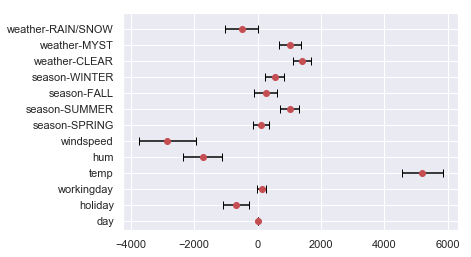

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = []
y = []
xerr_0025 = []
xerr_0975 = []

xerrs = result.conf_int()
xerr = []

for i in range(len(result.params)):
    xerr_0025.append(result.params[i] - xerrs[0][i])
    xerr_0975.append(xerrs[1][i] - result.params[i])
    x.append(result.params[i])
    y.append(i+1)
xerr = np.array([xerr_0025,  xerr_0975])

ax.errorbar(x, y, xerr=xerr, fmt='ro', capsize=4, ecolor='black')
plt.yticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14], 
           ['day', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
           'season-SPRING', 'season-SUMMER', 'season-FALL', 'season-WINTER',
           'weather-CLEAR', 'weather-MYST', 'weather-RAIN/SNOW' ])

plt.show()